In [1]:
!pip install -q transformers datasets tokenizers

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [4]:
emotion_dataset = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [5]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [8]:
emotion_dataset["train"]["label"][0]

0

In [9]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [10]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [11]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [12]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [13]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [14]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [15]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [16]:
# Если надо, попрактикуйся работать с токенайзером здесь
print(len(emotion_dataset["train"]["label"]))

16000


In [17]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.tokenizer.encode_plus(
            self.dataset[self.part]["text"][idx], 
            max_length=128, 
            padding = "max_length",
            return_tensors="pt"
        )
        label = self.dataset[self.part]["label"][idx]

        target = self.label2num[label]
        return {
            "input_ids": text['input_ids'],
            "mask": text['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [18]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation") # validation
test_dataset = TweetDataset("test")

In [19]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
  train_dataset, batch_size=batch_size,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [20]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь оптимайзер и критерий:

In [21]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [29]:
tokens = train_dataset[0]["input_ids"].to(device) # Получи токены из датасета
mask = train_dataset[0]["mask"].to(device) # Получи маску из датасета

model_0(input_ids=tokens, attention_mask=mask).logits # Посмотри на аутпут

tensor([[-0.1390, -0.2203, -0.3580,  0.3455,  0.0744, -0.7339]],
       device='cuda:0', grad_fn=<IndexBackward>)

In [31]:
a = torch.tensor([[1, 2, 3], [3, 2, 1], [1, 1, 1]])
print(a.argmax(dim=-1))

tensor([2, 0, 0])


In [33]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Mon Nov 22 18:25:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [34]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):

    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        predict = model_0(input_ids=batch["input_ids"].to(device).squeeze(1),
                            attention_mask=batch["mask"].to(device).squeeze(1)).logits
        loss = criterion(predict, batch["target"].to(device))
        train_loss += loss
        loss.backward()
        optimizer.step()
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            predict = model_0(input_ids=batch["input_ids"].to(device).squeeze(1),
                        attention_mask=batch["mask"].to(device).squeeze(1)).logits
            loss = criterion(predict, batch["target"].to(device))
            valid_loss += loss.item()
            valid_acc += torch.sum(predict.argmax(dim=-1).to('cpu') == batch["target"]) / len(batch["target"])

    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
# test_acc = 0
# model_0.eval()
# with torch.no_grad():
#     for batch in test_loader:
#         ...
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.4793102741241455,Valid Loss: 1.3210904523730278,Valid Acc: 0.48974609375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.1835739612579346,Valid Loss: 0.9955052435398102,Valid Acc: 0.63427734375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.856486976146698,Valid Loss: 0.8100444860756397,Valid Acc: 0.71484375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.61728435754776,Valid Loss: 0.6789055038243532,Valid Acc: 0.76416015625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.46336400508880615,Valid Loss: 0.6494605112820864,Valid Acc: 0.79296875


  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        predict = model_0(input_ids=batch["input_ids"].to(device).squeeze(1),
                           attention_mask=batch["mask"].to(device).squeeze(1)).logits

        test_acc += torch.sum(predict.argmax(dim=-1).to('cpu') == batch["target"]) / len(batch["target"])
        ...
print(f"Test Acc: {test_acc / len(test_loader)}")

Test Acc: 0.80029296875


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [35]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [50]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [51]:
text = emotion_dataset["validation"]["text"][0]# Выбери текст из датасета
tokens = tokenizer.tokenize(text)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


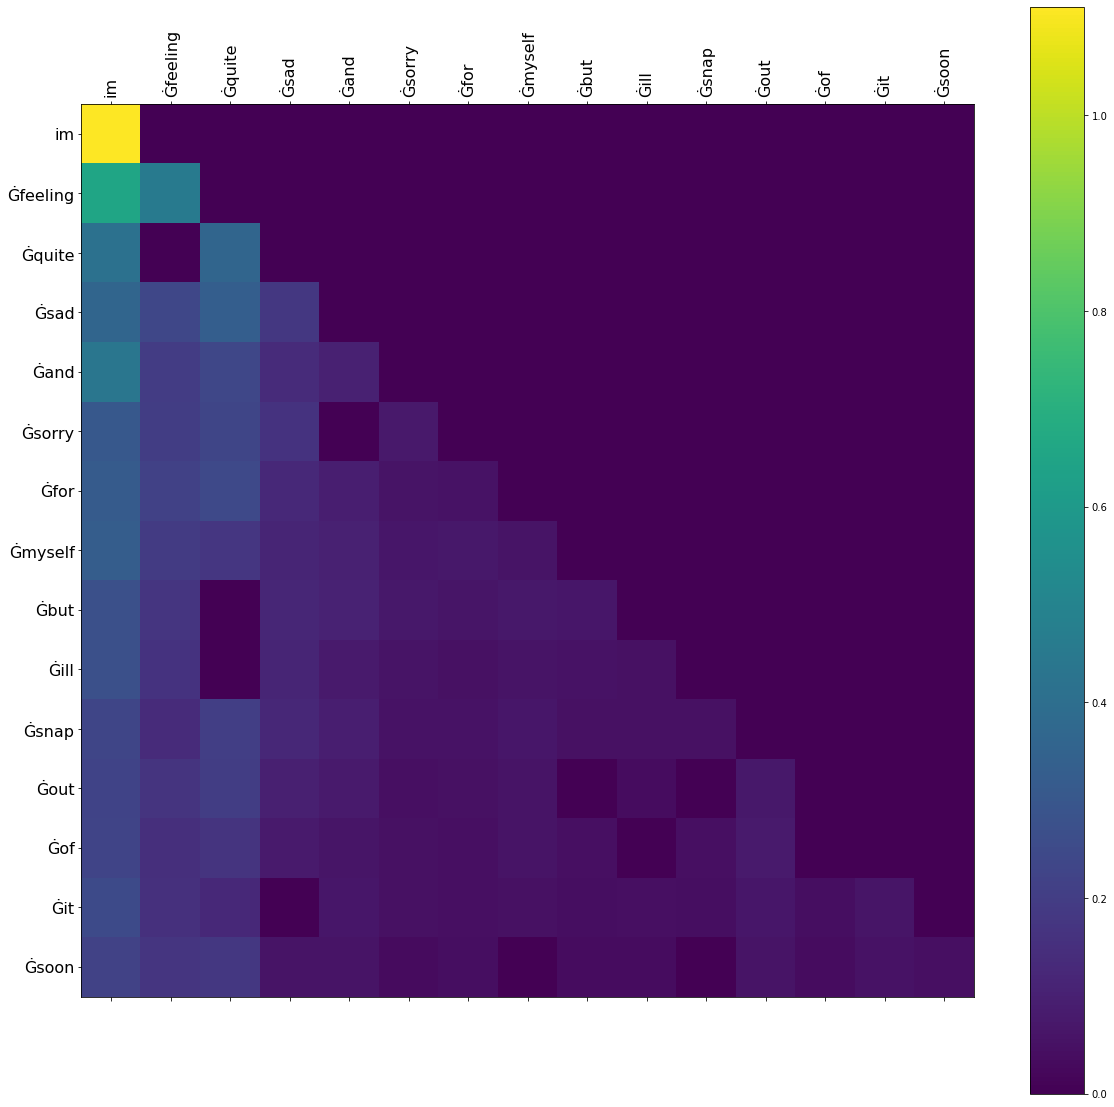

In [52]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [58]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [60]:
from tqdm.notebook import tqdm


num_epochs = 4

# Train loop
for e in range(num_epochs):

    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        predict = model_1(input_ids=batch["input_ids"].to(device).squeeze(1),
                            attention_mask=batch["mask"].to(device).squeeze(1)).logits
        loss = criterion(predict, batch["target"].to(device))
        train_loss += loss
        loss.backward()
        optimizer.step()
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            predict = model_1(input_ids=batch["input_ids"].to(device).squeeze(1),
                        attention_mask=batch["mask"].to(device).squeeze(1)).logits
            loss = criterion(predict, batch["target"].to(device))
            valid_loss += loss.item()
            valid_acc += torch.sum(predict.argmax(dim=-1).to('cpu') == batch["target"]) / len(batch["target"])

    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        predict = model_1(input_ids=batch["input_ids"].to(device).squeeze(1),
                           attention_mask=batch["mask"].to(device).squeeze(1)).logits

        test_acc += torch.sum(predict.argmax(dim=-1).to('cpu') == batch["target"]) / len(batch["target"])
        ...
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.6471072435379028,Valid Loss: 1.067800348624587,Valid Acc: 0.615234375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7405943274497986,Valid Loss: 0.4021357586607337,Valid Acc: 0.86328125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.3665081262588501,Valid Loss: 0.26218486297875643,Valid Acc: 0.9072265625


  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [61]:
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        predict = model_1(input_ids=batch["input_ids"].to(device).squeeze(1),
                           attention_mask=batch["mask"].to(device).squeeze(1)).logits

        test_acc += torch.sum(predict.argmax(dim=-1).to('cpu') == batch["target"]) / len(batch["target"])
        ...
print(f"Test Acc: {test_acc / len(test_loader)}")

Test Acc: 0.9072265625


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [62]:
text = emotion_dataset["validation"]["text"][0]# Выбери текст из датасета
tokens = tokenizer.tokenize(text)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


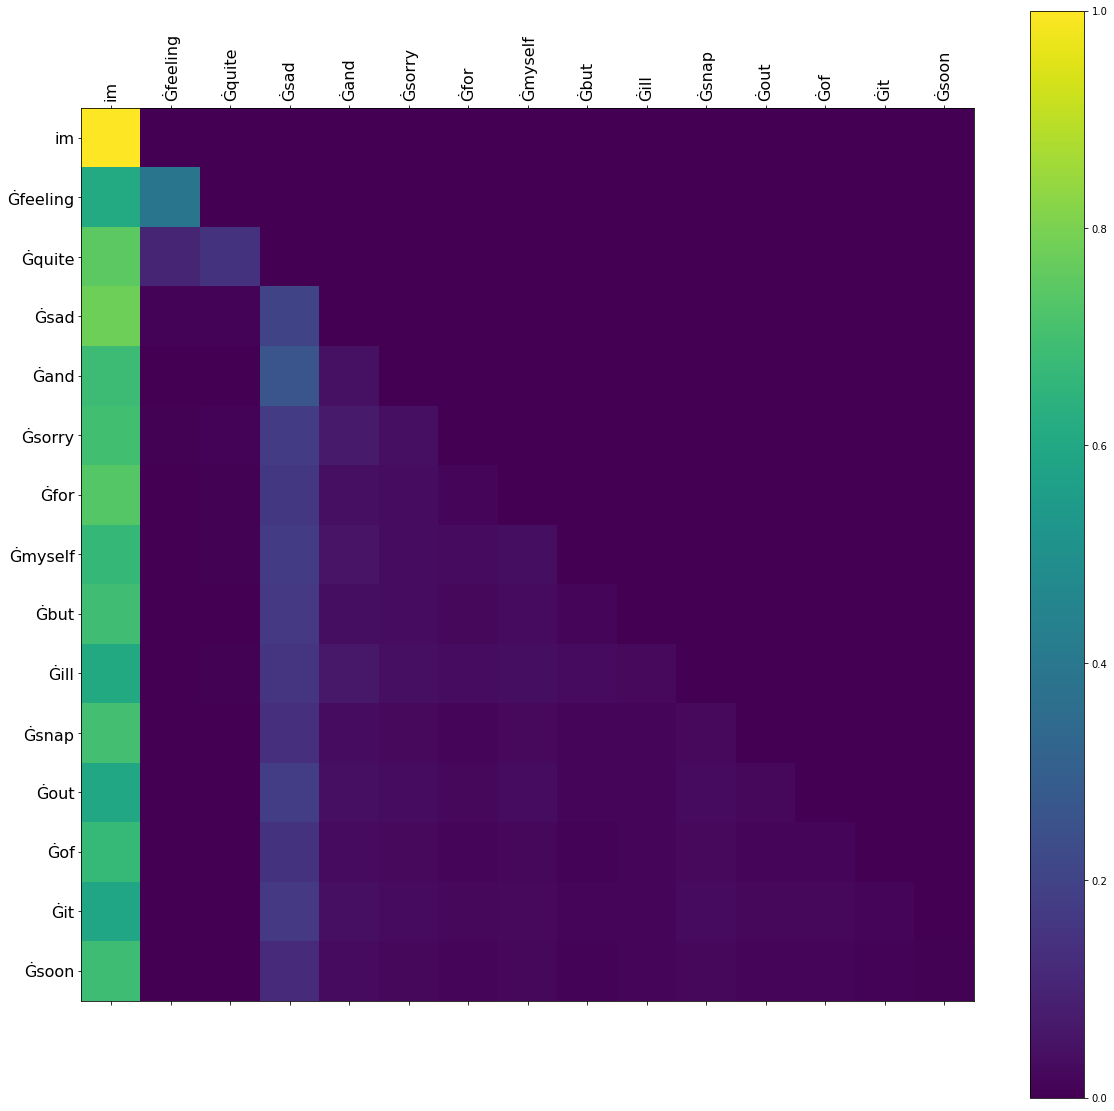

In [68]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


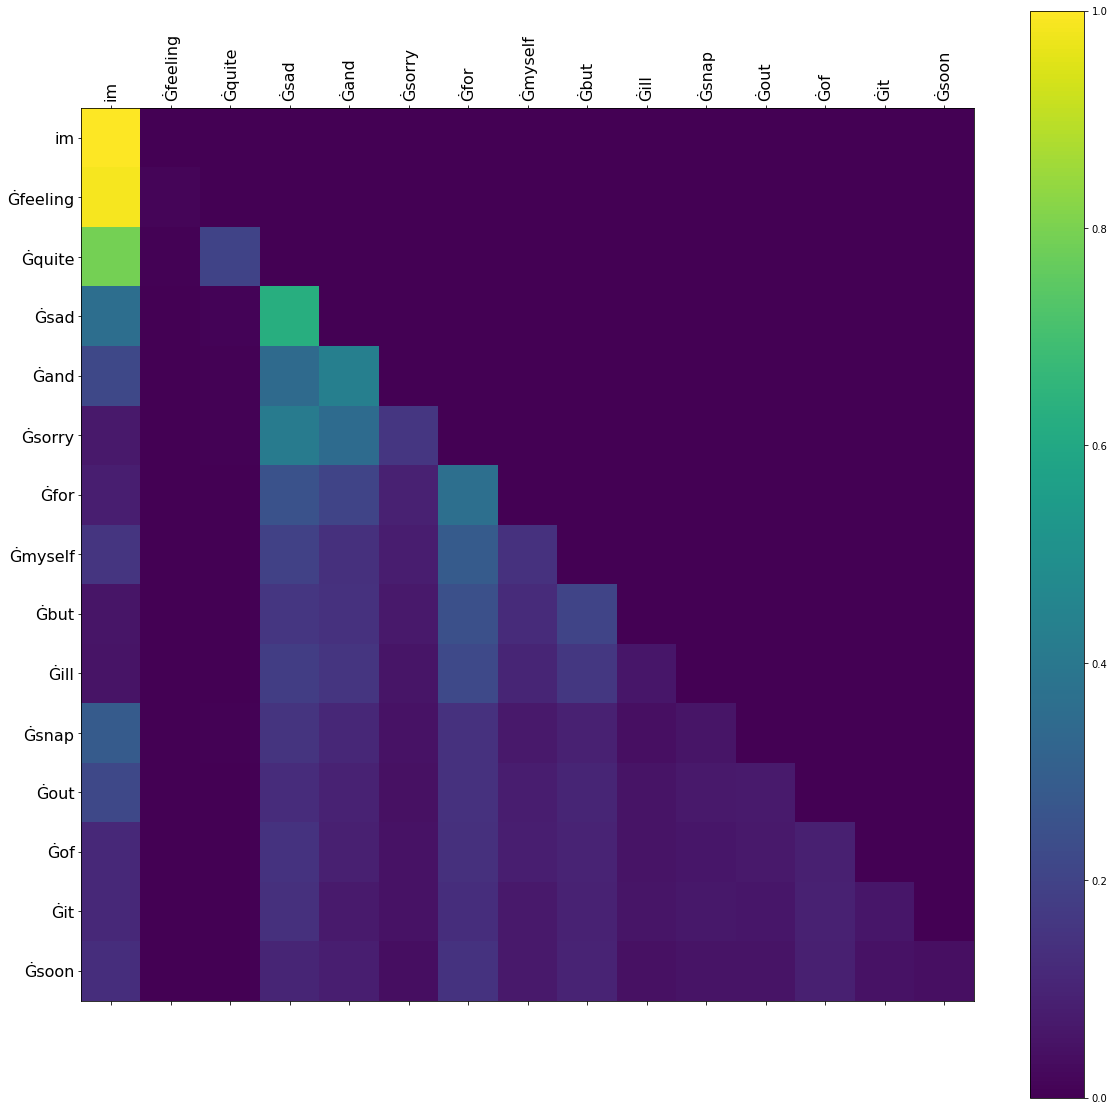

In [69]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


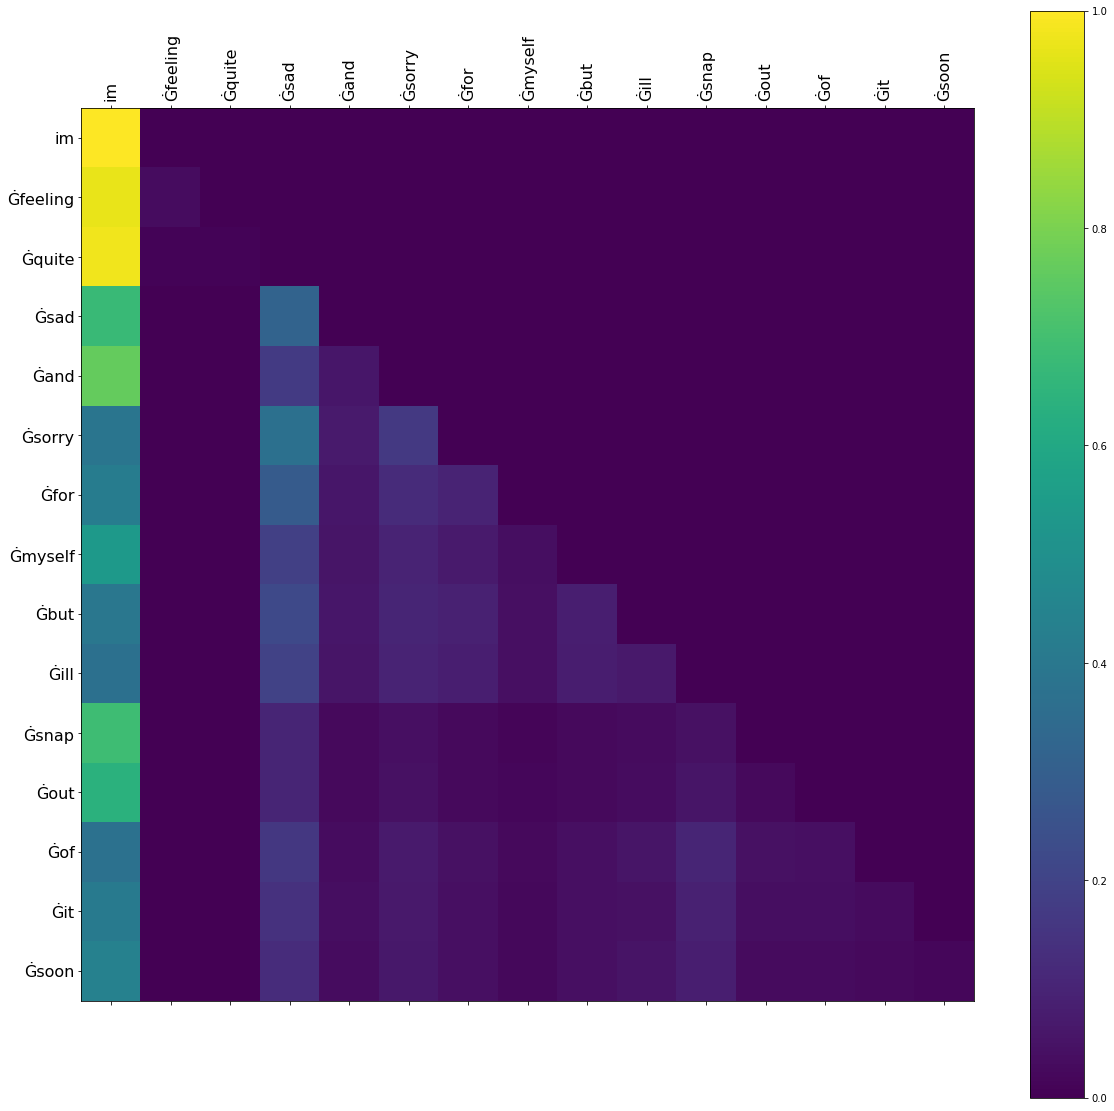

In [74]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][2])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

In [ ]:
Предобученная можель показала результаты сильно выше: 0.91 против 0.8, хотя обучалась на 2 эпохи меньше.
1 слой обращает внимание на первое слово
2 слой обращает внимание на предыдущее слово